In [1]:
import pandas as pd
from venn import venn
import csv
import matplotlib.pyplot as plt
import enriching_utils

# the following script needs to be installed from github.com/kbrbe/enrich-authority-csv
from enrich_authority_csv.enrich_authority_csv import main as enrich_authority_csv

# Increase contributor overlap

This notebook contains code to increase the overlap of person contributors as well as to enrich missing nationality information. The following files will be used or are created:

* input-contributor-list: the current list of all person contributors of BELTRANS data (`all-persons.csv`)
* bnf-belgian-list: A list of Belgians from the BnF catalogue
* nta-belgian-list: A list of Belgians from the KB catalogue
* enriched-list: the enriched list, created based on the input-contributor list after the first enriching step of  via the ISNI SRU API and updated with the other enrichment sources

The following steps will be performed

1. Fetch missing identifiers, nationalities and gender information from ISNI via the provided SRU API
2. Annotate missing nationality based on an existing list of BnF persons that are Belgian
3. Annotate missing nationality based on an existing list of NTA persons that are Belgian
4. Annotate missing nationality based on the BnF SRU API
5. ~Annotate missing nationality based on the KB SRU API~
6. Check for duplicate rows
7. Manual check to uniformize the columns with information about nationality and gender



## Fetch missing data via ISNI SRU

In [2]:
# the input data
personCorrelationListFile = './corpus-versions/2023-06-06/csv/all-persons.csv'
personCorrelationListEnrichedFile = '../data-sources/correlation/2023-06-28_person-contributors-correlation-list.csv'
bnfBelgiansFile = './BnF_Personnes_Belges_2023-06-14.xlsx'
ntaBelgiansFile = 'KB_NTA_Belgen_ISNI_naam_20230620.xlsx'
enrichedFinalFile = '../data-sources/correlation/2023-06-28_person-contributors-correlation-list-processed.csv'

downloadAgain = False

In [3]:
if downloadAgain:
    enrich_authority_csv(
      configFile='/home/slieber/repos/kbr/enrich-authority-csv/config-example.json',
      inputFile=personCorrelationListFile,
      outputFile=personCorrelationListEnrichedFile,
      apiName='ISNI',
      query='pica.isn =',
      recordSchema='isni-e',
      dataFields={
          'kbrIDs': 'KBR',
          'bnfIDs': 'BNF',
          'ntaIDs': 'NTA',
          'nationalities': 'nationality',
          'gender': 'gender'},
      delimiter=',',
      secondsBetweenAPIRequests=0,
      identifierColumnName='isniIDs')

In [4]:
# Read the original correlation list and the enriched one into pandas data frames
dfBeforeEnrichment = enriching_utils.readCorrelationList(personCorrelationListFile)
dfAfterEnrichment = enriching_utils.readCorrelationList(personCorrelationListEnrichedFile)

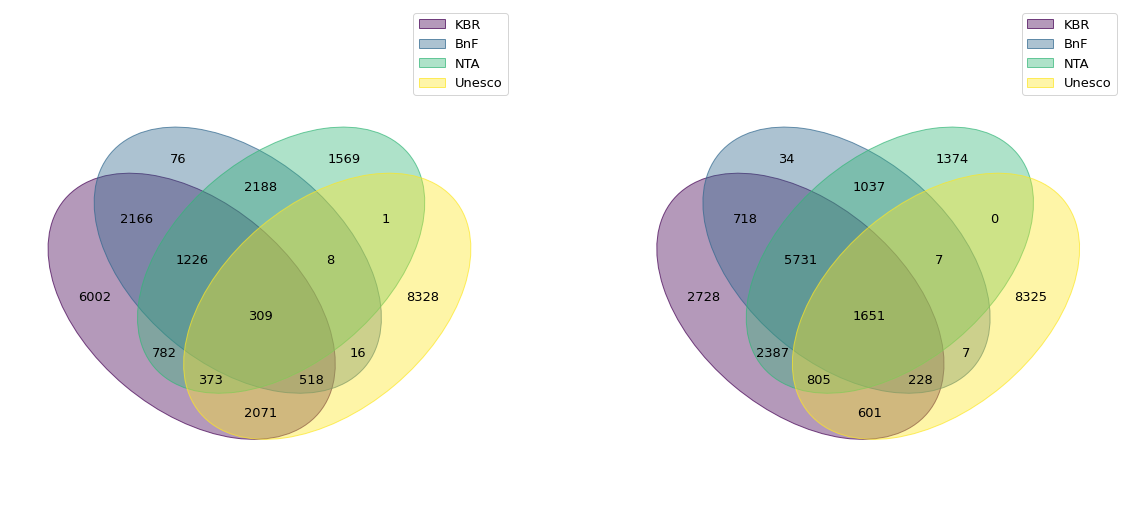

In [5]:
# Venn diagram before and after enrichment via ISNI database
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
enriching_utils.createBELTRANSVennDiagram(dfBeforeEnrichment, fig=ax1)
enriching_utils.createBELTRANSVennDiagram(dfAfterEnrichment, fig=ax2)

## Annotate missing nationality (BnF list)
One row in the correlation list may have several BnF identifiers separated with a semicolon.
For a matching with the list of BnF Belgians we need one BnF identifier per row.
We use the `explode` method of pandas to basically duplicate a row with several BnF identifiers.

In [6]:
bnfBelgians = pd.read_excel(bnfBelgiansFile,
                           sheet_name='BnF_Personnes_Belges_Export-Pro',
                           index_col='Identifiant ARK')

In [7]:
correlationListBnF = enriching_utils.prepareMissingNationalityList(dfAfterEnrichment, 'bnfIDs', 'singleBnFID')

Number of missing bnfIDs nationalities: 278
Number of missing bnfIDs nationalities (after exploding): 280


In [8]:
# show one 'exploded' example
correlationListBnF.loc[['76a84dc7-961b-4ec5-9dea-7c3aacb818c4']]

,name,names,birthDate,deathDate,authorIn,translatorIn,illustratorIn,scenaristIn,publishingDirectorIn,textPseudonymOf,...,gender,kbrIDs,bnfIDs,ntaIDs,unescoIDs,unescoIDsLong,isniIDs,viafIDs,wikidataIDs,singleBnFID
contributorID,,,,,,,,,,,,,,,,,,,,,
76a84dc7-961b-4ec5-9dea-7c3aacb818c4,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,...,NaN,14530001,cb14550787f;cb16421341r,p071906495,NaN,NaN,0000000070067586,37156029;263398247,Q158208,cb14550787f
76a84dc7-961b-4ec5-9dea-7c3aacb818c4,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,...,NaN,14530001,cb14550787f;cb16421341r,p071906495,NaN,NaN,0000000070067586,37156029;263398247,Q158208,cb16421341r


The list of Belgians from BnF uses the ark identifier as key, thus e.g. `ark:/12148/cb1234`  instead of `1234`.
In the following step we add a new column `ark` to our correlation list such that we can try to match the correlation list and the list of Belgians from BnF

In [9]:
correlationListBnF['ark'] = 'ark:/12148/' + correlationListBnF['singleBnFID']

The following example illustrates that there is indeed now a column with the same identifier format for the comparison.

In [10]:
correlationListBnFExample = correlationListBnF['ark'][0]
bnfBelgiansExample = bnfBelgians.index[0]

print(f'correlation:\t{correlationListBnFExample}\nbnfBelgians:\t{bnfBelgiansExample}')

correlation:	ark:/12148/cb14584821c
bnfBelgians:	ark:/12148/cb14443837h


In [11]:
# as seen above, the identifiers have the same structure now, let's find matches
identifiedBnFBelgians = correlationListBnF.merge(bnfBelgians, left_on='ark', right_index=True, suffixes=('', '_y'))

In [12]:
identifiedBnFBelgians

,name,names,birthDate,deathDate,authorIn,translatorIn,illustratorIn,scenaristIn,publishingDirectorIn,textPseudonymOf,...,200$a,200$b,200$f,300$a,856$u,Column1,_2,_3,_4,_5
contributorID,,,,,,,,,,,,,,,,,,,,,


The output above either shows matches or is empty if no matches were found. The following command adds the Belgian nationality to the records found in the Belgian list

In [13]:
dfAfterEnrichment.loc[dfAfterEnrichment.index.isin(identifiedBnFBelgians.index), 'nationalities'] = 'Belgium'

## Annotate missing nationality (NTA list)

In [14]:
ntaBelgians = pd.read_excel(ntaBelgiansFile,
                           index_col='s')

In [15]:
correlationListNTA = enriching_utils.prepareMissingNationalityList(dfAfterEnrichment, 'ntaIDs', 'singleNTAID')

Number of missing ntaIDs nationalities: 3501
Number of missing ntaIDs nationalities (after exploding): 3503


The list of Belgians from NTA uses a URI as key, thus e.g. `http://data.bibliotheken.nl/id/thes/p1234`  instead of `p1234`.
In the following step we add a new column `uri` to our correlation list such that we can try to match the correlation list and the list of Belgians from NTA

In [16]:
correlationListNTA['uri'] = 'http://data.bibliotheken.nl/id/thes/' + correlationListNTA['singleNTAID']

The following example illustrates that there is indeed now a column with the same identifier format for the comparison.

In [17]:
correlationListNTAExample = correlationListNTA['uri'][0]
ntaBelgiansExample = ntaBelgians.index[0]

print(f'correlation:\t{correlationListNTAExample}\nntaBelgians:\t{ntaBelgiansExample}')

correlation:	http://data.bibliotheken.nl/id/thes/p175535779
ntaBelgians:	http://data.bibliotheken.nl/id/thes/p420756329


In [18]:
# as seen above, the identifiers have the same structure now, let's find matches
identifiedNTABelgians = correlationListNTA.merge(ntaBelgians, left_on='uri', right_index=True, suffixes=('', '_y'))

In [19]:
identifiedNTABelgians

,name,names,birthDate,deathDate,authorIn,translatorIn,illustratorIn,scenaristIn,publishingDirectorIn,textPseudonymOf,...,ntaIDs,unescoIDs,unescoIDsLong,isniIDs,viafIDs,wikidataIDs,singleNTAID,uri,isni,name_y
contributorID,,,,,,,,,,,,,,,,,,,,,
6625,"Van Humbeeck, Sabine",NaN,NaN,NaN,0,58,0,0,0,NaN,...,p167698672,u476,u5605ff7cf42c28db63c77aa5b3ff73c2,000000001272631X,NaN,NaN,p167698672,http://data.bibliotheken.nl/id/thes/p167698672,NaN,NaN
3623032a-fd78-4515-80af-1df903fbc703,Eddy Keymolen,NaN,NaN,NaN,0,0,0,0,0,NaN,...,p407375694,NaN,NaN,NaN,31148933685254302607,NaN,p407375694,http://data.bibliotheken.nl/id/thes/p407375694,NaN,NaN
8f94cd66-cf54-41df-973c-5ed468cacd11,B. Ceuppens,NaN,NaN,NaN,0,0,0,0,0,NaN,...,p072654775,NaN,NaN,NaN,288663427,NaN,p072654775,http://data.bibliotheken.nl/id/thes/p072654775,NaN,NaN
a52331ca-9aa0-48b4-8e54-f34f913a7ec0,Marina Eggermont,NaN,NaN,NaN,0,0,0,0,0,NaN,...,p399282718,NaN,NaN,NaN,96147266985635482875,NaN,p399282718,http://data.bibliotheken.nl/id/thes/p399282718,NaN,NaN
56937934-4f56-4469-9c68-414bfe2fc91a,Wendy Wagemans,NaN,NaN,NaN,0,0,0,0,0,NaN,...,p407899286,NaN,NaN,0000000464464998,18148035612787970531,NaN,p407899286,http://data.bibliotheken.nl/id/thes/p407899286,http://www.isni.org/isni/0000000464464998,Wendy Wagemans
2346,"Dodion, Lotte",NaN,NaN,NaN,1,0,0,0,0,NaN,...,p401323528,NaN,NaN,000000046104498X,NaN,NaN,p401323528,http://data.bibliotheken.nl/id/thes/p401323528,NaN,NaN
2544,"Eloy, Michel",NaN,NaN,NaN,2,0,0,0,0,NaN,...,p438089065,NaN,NaN,000000013954306X,NaN,NaN,p438089065,http://data.bibliotheken.nl/id/thes/p438089065,NaN,NaN
b1c50749-ba71-455d-8283-26d6d05f1246,"Van den Hende, Karin",NaN,NaN,NaN,0,0,0,0,0,NaN,...,p326813675,NaN,NaN,0000000396382519,NaN,NaN,p326813675,http://data.bibliotheken.nl/id/thes/p326813675,http://www.isni.org/isni/0000000396382519,Karin Van den Hende
fd29d9c1-d404-48b2-9d1d-e90e23b98b85,Lieve Delanote,NaN,NaN,NaN,0,0,0,0,0,NaN,...,p409725951,NaN,NaN,NaN,668149294565780522829,NaN,p409725951,http://data.bibliotheken.nl/id/thes/p409725951,NaN,NaN


The output above either shows matches or is empty if no matches were found.
The following command adds the Belgian nationality to the records found in the Belgian list

In [20]:
dfAfterEnrichment.loc[dfAfterEnrichment.index.isin(identifiedNTABelgians.index), 'nationalities'] = 'Belgium'

## Enrich nationality via BnF SRU API

We try next to fetch the missing nationality information from the BnF Search/Retrieve via URL (SRU) API. We also use the ISNI identifier and the SRU search key `aut.isni`.

In [21]:
# create a CSV file with BnF identifiers to look up

tmpEnriched = 'tmp-enriched.csv'
tmpEnrichedAndNat = 'tmp-enriched-nat.csv'

In [22]:
if downloadAgain:
    # the script below reads a file row by row, 
    # thus we first have to serialize the current frame to a file that can be read as input
    dfAfterEnrichment.to_csv(tmpEnriched)
    
    enrich_authority_csv(
      configFile='/home/slieber/repos/kbr/enrich-authority-csv/config-example.json',
      inputFile=tmpEnriched,
      outputFile=tmpEnrichedAndNat,
      apiName='BnF',
      query='aut.isni all',
      recordSchema='unimarcxchange',
      dataFields={'nationalities': 'nationality'},
      delimiter=',',
      secondsBetweenAPIRequests=0,
      identifierColumnName='isniIDs')
    

In [23]:
# Create local BnF identifiers, needed if we want to lookup things at BnF using the BnF identifier.
#dfAfterEnrichment['bnfLocalID'] = dfAfterEnrichment.apply(lambda row: enriching_utils.computeLocalBnFIdentifier(row, 'bnfIDs'), axis=1)
#correlationListBnFNorm['singleBnFID'].to_csv('tmp_bnfIDs-without-nationality.csv')

In [24]:
dfAfterSecondEnrichment = enriching_utils.readCorrelationList(tmpEnrichedAndNat)

## Enrich nationality via KB SRU API
Currently we don't know which search keys we can use for the KB SRU API, nor which SRU endpoint we can use for books. Existing endpoints seem to work only on specified collections such as newspapers.

## Check for duplicate rows

In [25]:
enriching_utils.countDuplicateDifference(dfBeforeEnrichment, dfAfterSecondEnrichment, 'kbrIDs')
enriching_utils.countDuplicateDifference(dfBeforeEnrichment, dfAfterSecondEnrichment, 'bnfIDs')
enriching_utils.countDuplicateDifference(dfBeforeEnrichment, dfAfterSecondEnrichment, 'ntaIDs')
enriching_utils.countDuplicateDifference(dfBeforeEnrichment, dfAfterSecondEnrichment, 'unescoIDs')

Duplicate kbrIDs before: 1 and after 2
Duplicate bnfIDs before: 2 and after 2
Duplicate ntaIDs before: 3 and after 4
Duplicate unescoIDs before: 0 and after 0


In [26]:
dfAfterSecondEnrichment.loc[dfAfterSecondEnrichment.duplicated(keep=False),:]

,name,names,birthDate,deathDate,authorIn,translatorIn,illustratorIn,scenaristIn,publishingDirectorIn,textPseudonymOf,...,nationalities,gender,kbrIDs,bnfIDs,ntaIDs,unescoIDs,unescoIDsLong,isniIDs,viafIDs,wikidataIDs
contributorID,,,,,,,,,,,,,,,,,,,,,
8ffab6fd-e40b-42bf-ab84-241d74e6b13d,Jean Bruce,NaN,NaN,NaN,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,p072170204;p28983239X,NaN,NaN,NaN,34466647,Q255754
2ddfb3e8-f308-4a0d-9dd6-66fc79b37d2c,Robert Duchesne,NaN,NaN,NaN,0,0,0,0,0,NaN,...,France,Male,NaN,cb102369707;cb11900901p,p202161293,NaN,NaN,0000000071335271,100261958;36917460,NaN
76a84dc7-961b-4ec5-9dea-7c3aacb818c4,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,...,XX,NaN,14530001,cb14550787f;cb16421341r,p071906495,NaN,NaN,0000000070067586,37156029;263398247,Q158208
11f01574-a076-4e33-bdeb-281ae052f2c2,Jean Bruce,NaN,NaN,NaN,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,p072170204;p28983239X,NaN,NaN,NaN,34466647,Q255754
4ff73b90-95f5-4c87-bcee-cdcdce811128,Robert Duchesne,NaN,NaN,NaN,0,0,0,0,0,NaN,...,France,Male,NaN,cb102369707;cb11900901p,p202161293,NaN,NaN,0000000071335271,100261958;36917460,NaN
8621fdbe-20b6-4136-a401-db890330d182,"Geysels, Luc",NaN,NaN,NaN,0,0,0,0,0,NaN,...,Belgium,Male,14103180;14118729,NaN,p12021492X,NaN,NaN,000000039125426X,NaN,NaN
ca33d477-ccca-4211-80cd-bb38bf9cce5f,"Geysels, Luc",NaN,NaN,NaN,0,0,0,0,0,NaN,...,Belgium,Male,14103180;14118729,NaN,p12021492X,NaN,NaN,000000039125426X,NaN,NaN
d87e88b2-e11e-4f6b-92b8-d67d95348f49,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,...,XX,NaN,14530001,cb14550787f;cb16421341r,p071906495,NaN,NaN,0000000070067586,37156029;263398247,Q158208


## Manual check to uniformize columns
This mainly concerns the columns `nationalities` and `gender` since these were enriched in this notebook from ISNI and BnF. We will first provide some statistics of used values and based on that define a mapping list based on which we can automatically replace the values.

In [27]:


nationalityDf = enriching_utils.createExplodedList(dfAfterSecondEnrichment, 'nationalities', 'singleNationality')
genderDf = enriching_utils.createExplodedList(dfAfterSecondEnrichment, 'gender', 'singleGender')

Number of non empty nationalities values: 11097
Number of non empty nationalities values (after exploding): 11513
Number of non empty gender values: 11943
Number of non empty gender values (after exploding): 11970


In [28]:
pd.set_option("display.max_rows", None)
nationalityDf['singleNationality'].value_counts()
pd.set_option("display.max_rows", 100)

We want to create a uniform country codes column. Therefore we will read in a CSV file containing a mapping between country names in English and their ISO-3166 country code (that is also used by the LoC countries vocabulary).

From the enrichment step above we also got country codes but they are often uppercased. Hence we want to first replace country names with proper lowercased country codes and in a second step replace uppercased country codes with proper lowercased country codes.

After manual insepection we have seen some invalid country codes, so we add some additional mapping rules to map those to correct ISO-3166 country codes

In [29]:
# create two mapping dictionaries, one from the English country name to lowercased country code
# and one from case insensitive-regex country code to lowercased country code
nationalityMapping = {}
countryCodeMapping = {}
with open('country-code-mapping.csv') as inFile:
    inputReader = csv.DictReader(inFile)
    for row in inputReader:
        nationalityMapping[row['countryNameEN']] = row['countryCode']
        countryCodeMapping['(?i)' + row['countryCode']] = row['countryCode']


# first replace all country name with codes, for example Belgium -> be
dfAfterSecondEnrichment['nationalityCountryCodes'] = dfAfterSecondEnrichment['nationalities'].replace(nationalityMapping, regex=True)

In [30]:
# manually add country code mappings for invalid data we manually found after the first execution of the step above
countryCodeMapping['DE'] = 'gw' # Germany
countryCodeMapping['US'] = 'xxu'# United States
countryCodeMapping['PT'] = 'po' # Portugal
countryCodeMapping['RS'] = 'rb' # Serbia
countryCodeMapping['AR'] = 'ag' # Argentina
countryCodeMapping['CN'] = 'cc' # China
countryCodeMapping['VN'] = 'vm' # Vietnam
countryCodeMapping['DZ'] = 'ae' # Algeria
countryCodeMapping['KR'] = 'ko' # South Korea
countryCodeMapping['IL'] = 'is' # Israel
countryCodeMapping['(?i)cc \(republic : 1949- \)'] = 'ch' # Republic of China
countryCodeMapping['IN'] = 'ii' # India
countryCodeMapping['MA'] = 'mr' # Morocco
countryCodeMapping['(?i)russia \(Federation\)'] = 'ru' # Russian Federation
countryCodeMapping['(?i)congo \(Democratic republic\)'] = 'cg' # Congo
countryCodeMapping['CZ'] = 'xr' # Czech republic
countryCodeMapping['RO'] = 'rm' # Romania
countryCodeMapping['ID'] = 'io' # Indonesia
countryCodeMapping['JP'] = 'ja' # Japan
countryCodeMapping['GE'] = 'gs' # Georgia
countryCodeMapping['BY'] = 'bw' # Belarus
countryCodeMapping['TN'] = 'ti' # Tunisia
countryCodeMapping['AL'] = 'aa' # Albania
countryCodeMapping['MD'] = 'mv' # Moldova
countryCodeMapping['EE'] = 'er' # Estonia
countryCodeMapping['KP'] = 'kn' # North Korea


In [31]:
# the new column may still have non replaced values
# such as countries that already had (uppercased) country codes
# also replace those, for example DE -> de
dfAfterSecondEnrichment['nationalityCountryCodes'] = dfAfterSecondEnrichment['nationalityCountryCodes'].replace(countryCodeMapping, regex=True)

dfAfterSecondEnrichment['nationalityCountryCodes'].value_counts()

fr          4509
be          3876
ne           816
xx           327
it           168
            ... 
ca;vm;ca       1
ic             1
xxu;us         1
cd;cd          1
bi             1
Name: nationalityCountryCodes, Length: 240, dtype: int64

In [32]:
dfExplodedNationalities = enriching_utils.createExplodedList(dfAfterSecondEnrichment, 'nationalityCountryCodes', 'singleCountryCode')

Number of non empty nationalityCountryCodes values: 11097
Number of non empty nationalityCountryCodes values (after exploding): 11513


In [ ]:
# Remove double nationalities such as 'be;be'
# TODO (for now not very important, because when mapping it to RDF the double triples don't count)

In [33]:
#dfExplodedNationalities['singleCountryCode'].value_counts().to_csv('country-code-stats.csv')

In [34]:
genderMapping = {
    '^male': 'Male',
    '^female': 'Female',
    ';?unknown': ''
}
dfAfterSecondEnrichment['gender'].value_counts()

Male              8001
Female            3342
male               412
female             131
unknown             30
male;unknown        14
Female;Male         11
female;unknown       2
Name: gender, dtype: int64

In [35]:
dfAfterSecondEnrichment['gender'].replace(genderMapping, inplace=True, regex=True)
dfAfterSecondEnrichment['gender'].value_counts()

Male           8427
Female         3475
                 30
Female;Male      11
Name: gender, dtype: int64

In [36]:
dfAfterSecondEnrichment.to_csv(enrichedFinalFile)